In [3]:
import numpy as np 
import os
import pandas as pd 
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt

tf.disable_eager_execution()
import shutil
import tensorflow_hub as hub
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from PIL import Image, ImageOps


from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import tensorflow.keras.optimizers
from keras.api._v2.keras.optimizers import legacy
from keras.src.optimizers.legacy.adam import Adam
import random
random.seed(42)
np.random.seed(42)
tf.random.set_random_seed(42)

In [4]:
def load_dataset(directory):
    def extract_label(file_path):
        """
        Extract the subject label from the file path.
        Example: '/path/to/s01/image.jpg' -> 's01'
        """
        return os.path.basename(os.path.dirname(file_path))
    images = []
    labels = []
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                # Load and preprocess the image
                image = load_img(file_path, target_size=(299, 299))  # Resize as per Inception V3 input
                image = img_to_array(image)
                image /= 255.0  # Normalize to [0, 1]
                
                images.append(image)
                labels.append(extract_label(file_path))

    return np.array(images), np.array(labels)



In [5]:
train_dir = '/kaggle/input/subj-indep-data/augmented_faces/train'
train_images, train_labels = load_dataset(train_dir)

# Convert labels to numerical format
label_to_num = {label: idx for idx, label in enumerate(np.unique(train_labels))}
num_labels = len(label_to_num)

train_labels_num = np.array([label_to_num[label] for label in train_labels])

# One-hot encode labels
train_labels_encoded = to_categorical(train_labels_num, num_classes=num_labels)


In [6]:
test_dir = '/kaggle/input/subj-indep-data/augmented_faces/test'
test_images, test_labels = load_dataset(train_dir)

# Convert labels to numerical format
label_to_num = {label: idx for idx, label in enumerate(np.unique(test_labels))}
num_labels = len(label_to_num)

test_labels_num = np.array([label_to_num[label] for label in test_labels])

# One-hot encode labels
test_labels_encoded = to_categorical(test_labels_num, num_classes=num_labels)

In [7]:
val_dir = '/kaggle/input/subj-indep-data/augmented_faces/val'
val_images, val_labels = load_dataset(val_dir)

# Convert labels to numerical format
label_to_num = {label: idx for idx, label in enumerate(np.unique(val_labels))}
num_labels = len(label_to_num)

val_labels_num = np.array([label_to_num[label] for label in val_labels])

# One-hot encode labels
val_labels_encoded = to_categorical(val_labels_num, num_classes=num_labels)

In [8]:


# Create a directory for saving numpy data if it doesn't exist
if not os.path.exists('numpy_data'):
    os.makedirs('numpy_data')

# Define the base directory path
base_dir = 'numpy_data'

# For Training Data
np.save(os.path.join(base_dir, 'train_images.npy'), train_images)
np.save(os.path.join(base_dir, 'train_labels_num.npy'), train_labels_num)
np.save(os.path.join(base_dir, 'train_labels_encoded.npy'), train_labels_encoded)

# For Test Data
np.save(os.path.join(base_dir, 'test_images.npy'), test_images)
np.save(os.path.join(base_dir, 'test_labels_num.npy'), test_labels_num)
np.save(os.path.join(base_dir, 'test_labels_encoded.npy'), test_labels_encoded)

# For Validation Data
np.save(os.path.join(base_dir, 'val_images.npy'), val_images)
np.save(os.path.join(base_dir, 'val_labels_num.npy'), val_labels_num)
np.save(os.path.join(base_dir, 'val_labels_encoded.npy'), val_labels_encoded)


In [9]:
base_model = InceptionV3(weights='imagenet', include_top=False)
for layer in base_model.layers:
    layer.trainable = False
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(40, activation='softmax')  # Assuming 50 classes
])

87910968/87910968 [==============================] - 1s 0us/step


In [10]:
for i, layer in enumerate(base_model.layers):
    print(f"Layer {i} | Name: {layer.name} | Type: {type(layer).__name__} | Trainable: {layer.trainable}")

Layer 0 | Name: input_1 | Type: InputLayer | Trainable: False
Layer 1 | Name: conv2d | Type: Conv2D | Trainable: False
Layer 2 | Name: batch_normalization | Type: BatchNormalization | Trainable: False
Layer 3 | Name: activation | Type: Activation | Trainable: False
Layer 4 | Name: conv2d_1 | Type: Conv2D | Trainable: False
Layer 5 | Name: batch_normalization_1 | Type: BatchNormalization | Trainable: False
Layer 6 | Name: activation_1 | Type: Activation | Trainable: False
Layer 7 | Name: conv2d_2 | Type: Conv2D | Trainable: False
Layer 8 | Name: batch_normalization_2 | Type: BatchNormalization | Trainable: False
Layer 9 | Name: activation_2 | Type: Activation | Trainable: False
Layer 10 | Name: max_pooling2d | Type: MaxPooling2D | Trainable: False
Layer 11 | Name: conv2d_3 | Type: Conv2D | Trainable: False
Layer 12 | Name: batch_normalization_3 | Type: BatchNormalization | Trainable: False
Layer 13 | Name: activation_3 | Type: Activation | Trainable: False
Layer 14 | Name: conv2d_4 | Ty

for i, layer in enumerate(base_model.layers):
    print(f"Layer {i} | Name: {layer.name} | Type: {type(layer).__name__} | Trainable: {layer.trainable}")


base_model = tf.keras.Sequential([
    hub.KerasLayer("https://www.kaggle.com/models/google/inception-v3/frameworks/TensorFlow2/variations/feature-vector/versions/2",
               trainable=True, arguments=dict(batch_norm_momentum=0.997))
])
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(50, activation='softmax')  # Assuming 50 classes for 50 subjects
])

In [11]:
optimizer = Adam(learning_rate = .001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [12]:
history = model.fit(
    train_images, 
    train_labels_encoded, 
    epochs=10,  # Adjust based on your requirements
    batch_size=32,  # Adjust based on your requirements
    validation_data=(val_images, val_labels_encoded)
)

Train on 2400 samples, validate on 120 samples
Epoch 1/10
2400/2400 [==============================] - ETA: 0s - loss: 2.2172 - accuracy: 0.5108

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


2400/2400 [==============================] - 23s 9ms/sample - loss: 2.2172 - accuracy: 0.5108 - val_loss: 1.0671 - val_accuracy: 0.7667
Epoch 2/10
2400/2400 [==============================] - 11s 4ms/sample - loss: 0.4688 - accuracy: 0.9325 - val_loss: 0.5698 - val_accuracy: 0.8500
Epoch 3/10
2400/2400 [==============================] - 11s 4ms/sample - loss: 0.1802 - accuracy: 0.9808 - val_loss: 0.4280 - val_accuracy: 0.8750
Epoch 4/10
2400/2400 [==============================] - 11s 4ms/sample - loss: 0.0850 - accuracy: 0.9954 - val_loss: 0.2886 - val_accuracy: 0.9333
Epoch 5/10
2400/2400 [==============================] - 11s 5ms/sample - loss: 0.0463 - accuracy: 1.0000 - val_loss: 0.2608 - val_accuracy: 0.9167
Epoch 6/10
2400/2400 [==============================] - 11s 5ms/sample - loss: 0.0295 - accuracy: 1.0000 - val_loss: 0.2320 - val_accuracy: 0.9250
Epoch 7/10
2400/2400 [==============================] - 11s 5ms/sample - loss: 0.0216 - accuracy: 1.0000 - val_loss: 0.2178 - val

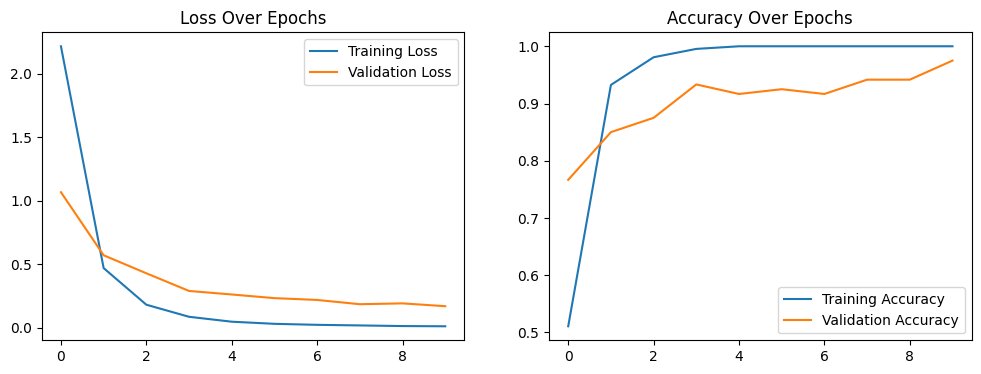

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

In [14]:
# Unfreeze from layer 276, mixed9_0
for layer in base_model.layers[276:]:
    layer.trainable = True
optimizer = Adam(learning_rate = .0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
history_fine_276 = model.fit(
    train_images, train_labels_encoded, 
    epochs=10,  # Adjust based on your requirements
    batch_size=32,  # Adjust based on your requirements
    validation_data=(val_images, val_labels_encoded)
)

Train on 2400 samples, validate on 120 samples
Epoch 1/10
2400/2400 [==============================] - 16s 6ms/sample - loss: 0.9989 - accuracy: 0.8963 - val_loss: 0.1284 - val_accuracy: 0.9667
Epoch 2/10
2400/2400 [==============================] - 12s 5ms/sample - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.0608 - val_accuracy: 0.9833
Epoch 3/10
2400/2400 [==============================] - 13s 5ms/sample - loss: 6.9257e-04 - accuracy: 1.0000 - val_loss: 0.0801 - val_accuracy: 0.9750
Epoch 4/10
2400/2400 [==============================] - 13s 5ms/sample - loss: 3.8770e-04 - accuracy: 1.0000 - val_loss: 0.0432 - val_accuracy: 0.9833
Epoch 5/10
2400/2400 [==============================] - 13s 5ms/sample - loss: 2.4764e-04 - accuracy: 1.0000 - val_loss: 0.0431 - val_accuracy: 0.9833
Epoch 6/10
2400/2400 [==============================] - 12s 5ms/sample - loss: 1.7437e-04 - accuracy: 1.0000 - val_loss: 0.0379 - val_accuracy: 0.9833
Epoch 7/10
2400/2400 [==============================] -

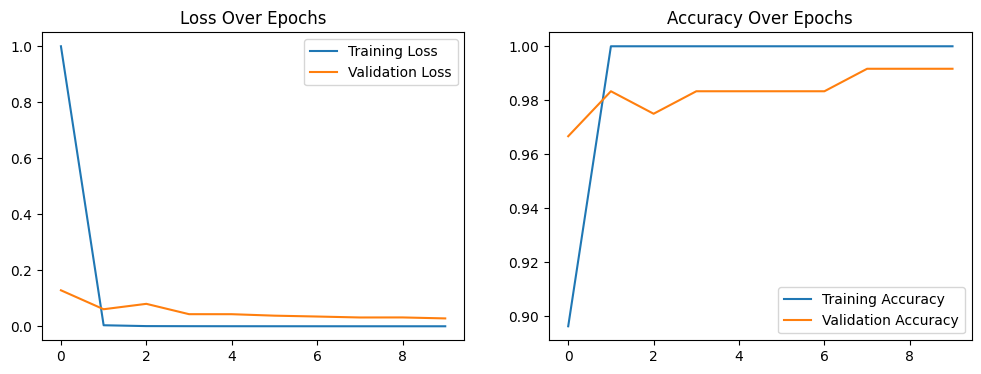

In [16]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_fine_276.history['loss'], label='Training Loss')
plt.plot(history_fine_276.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history_fine_276.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine_276.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

In [17]:
# Unfreeze from layer 248, mixed8
for layer in base_model.layers[248:]:
    layer.trainable = True
optimizer = Adam(learning_rate = .0003)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
history_fine_248 = model.fit(
    train_images, train_labels_encoded, 
    epochs=10,  # Adjust based on your requirements
    batch_size=32,  # Adjust based on your requirements
    validation_data=(val_images, val_labels_encoded)
)

Train on 2400 samples, validate on 120 samples
Epoch 1/10
2400/2400 [==============================] - 16s 7ms/sample - loss: 0.2095 - accuracy: 0.9496 - val_loss: 0.2424 - val_accuracy: 0.9250
Epoch 2/10
2400/2400 [==============================] - 14s 6ms/sample - loss: 0.0405 - accuracy: 0.9858 - val_loss: 0.0274 - val_accuracy: 0.9833
Epoch 3/10
2400/2400 [==============================] - 14s 6ms/sample - loss: 0.0070 - accuracy: 0.9971 - val_loss: 0.0624 - val_accuracy: 0.9833
Epoch 4/10
2400/2400 [==============================] - 14s 6ms/sample - loss: 0.0150 - accuracy: 0.9946 - val_loss: 0.0870 - val_accuracy: 0.9667
Epoch 5/10
2400/2400 [==============================] - 14s 6ms/sample - loss: 0.0119 - accuracy: 0.9962 - val_loss: 0.1411 - val_accuracy: 0.9500
Epoch 6/10
2400/2400 [==============================] - 14s 6ms/sample - loss: 0.0027 - accuracy: 0.9996 - val_loss: 0.1503 - val_accuracy: 0.9583
Epoch 7/10
2400/2400 [==============================] - 13s 5ms/sample 

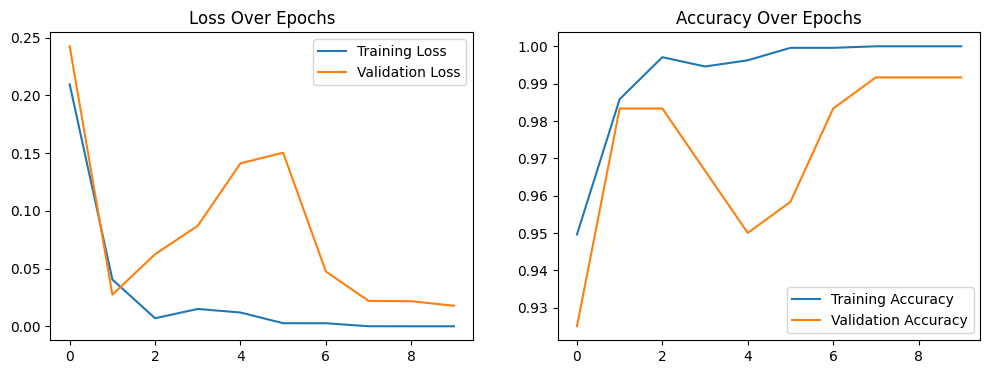

In [19]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_fine_248.history['loss'], label='Training Loss')
plt.plot(history_fine_248.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history_fine_248.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine_248.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

In [20]:
# Unfreeze from layer 228, mixed7
for layer in base_model.layers[228:]:
    layer.trainable = True
optimizer = Adam(learning_rate = .0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history_fine_228 = model.fit(
    train_images, train_labels_encoded, 
    epochs=10,  # Adjust based on your requirements
    batch_size=32,  # Adjust based on your requirements
    validation_data=(val_images, val_labels_encoded)
)

Train on 2400 samples, validate on 120 samples
Epoch 1/10
2400/2400 [==============================] - 17s 7ms/sample - loss: 0.0067 - accuracy: 0.9975 - val_loss: 0.2651 - val_accuracy: 0.9250
Epoch 2/10
2400/2400 [==============================] - 15s 6ms/sample - loss: 0.0034 - accuracy: 0.9987 - val_loss: 0.0299 - val_accuracy: 0.9833
Epoch 3/10
2400/2400 [==============================] - 15s 6ms/sample - loss: 1.4466e-05 - accuracy: 1.0000 - val_loss: 0.0204 - val_accuracy: 0.9833
Epoch 4/10
2400/2400 [==============================] - 15s 6ms/sample - loss: 6.2946e-06 - accuracy: 1.0000 - val_loss: 0.0192 - val_accuracy: 0.9917
Epoch 5/10
2400/2400 [==============================] - 14s 6ms/sample - loss: 4.6733e-06 - accuracy: 1.0000 - val_loss: 0.0187 - val_accuracy: 0.9917
Epoch 6/10
2400/2400 [==============================] - 15s 6ms/sample - loss: 3.6752e-06 - accuracy: 1.0000 - val_loss: 0.0182 - val_accuracy: 0.9917
Epoch 7/10
2400/2400 [==============================] -

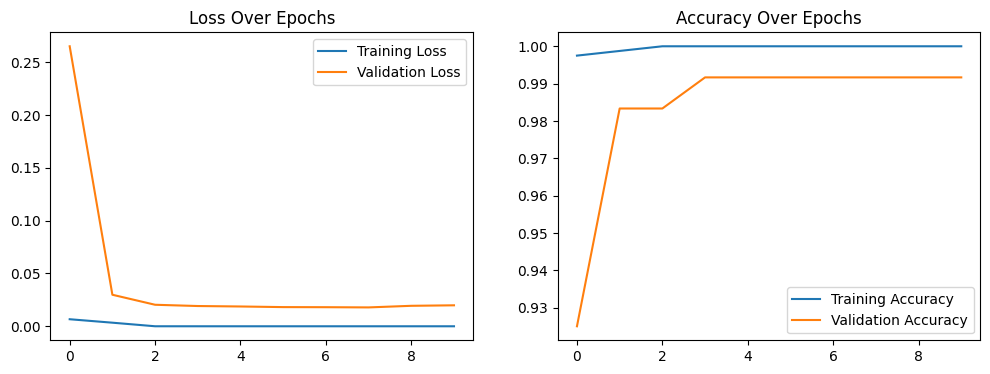

In [21]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_fine_228.history['loss'], label='Training Loss')
plt.plot(history_fine_228.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history_fine_228.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine_228.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

In [22]:
# Unfreeze from layer 196, mixed6
for layer in base_model.layers[196:]:
    layer.trainable = True
optimizer = Adam(learning_rate = .00005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history_fine_196 = model.fit(
    train_images, train_labels_encoded, 
    epochs=10,  # Adjust based on your requirements
    batch_size=32,  # Adjust based on your requirements
    validation_data=(val_images, val_labels_encoded)
)

Train on 2400 samples, validate on 120 samples
Epoch 1/10
2400/2400 [==============================] - 18s 8ms/sample - loss: 8.0344e-07 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 2/10
2400/2400 [==============================] - 16s 7ms/sample - loss: 0.0160 - accuracy: 0.9962 - val_loss: 0.0266 - val_accuracy: 0.9917
Epoch 3/10
2400/2400 [==============================] - 16s 7ms/sample - loss: 1.0705e-04 - accuracy: 1.0000 - val_loss: 0.0099 - val_accuracy: 1.0000
Epoch 4/10
2400/2400 [==============================] - 16s 7ms/sample - loss: 1.0943e-05 - accuracy: 1.0000 - val_loss: 0.0077 - val_accuracy: 1.0000
Epoch 5/10
2400/2400 [==============================] - 16s 7ms/sample - loss: 5.4655e-06 - accuracy: 1.0000 - val_loss: 0.0050 - val_accuracy: 1.0000
Epoch 6/10
2400/2400 [==============================] - 16s 7ms/sample - loss: 1.4804e-06 - accuracy: 1.0000 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 7/10
2400/2400 [=============================

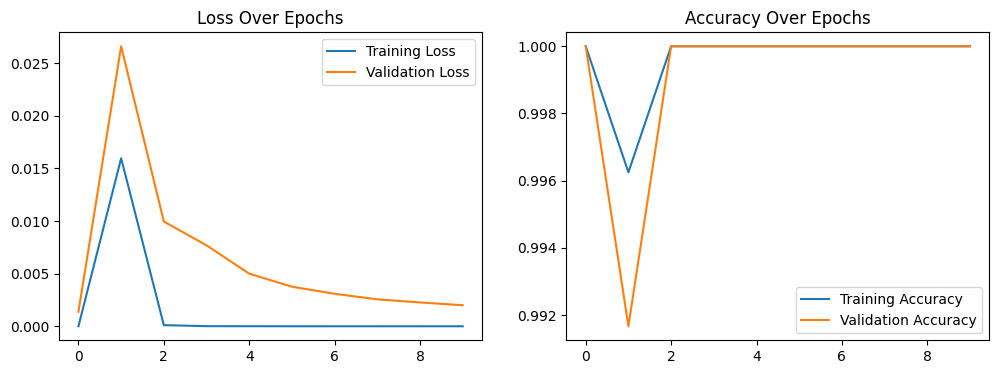

In [23]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_fine_196.history['loss'], label='Training Loss')
plt.plot(history_fine_196.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history_fine_196.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine_196.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

In [ ]:
if not os.path.exists('model'):
            os.makedirs('model')
model.save('model')